In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
# print(os.path.abspath(os.curdir))

import numpy as np
import matplotlib.pyplot as plt

import rfcutils # this corresponds to utility functions provided for the challenge

In [2]:
get_sinr = lambda s, i: 10*np.log10(np.mean(np.abs(s)**2)/np.mean(np.abs(i)**2))

---

# Signal Types

There are 3 kinds of RF signals in this dataset -- `EMISignal1`, `CommSignal2` and `CommSignal3`.

Examples of these signal types can be found in the respective folder under `dataset/train_frame/[Signal Type]`.

`dataset/train_frame/[Signal Type]`: Examples in this folder corresponds to a frame of 'typical length' of the particular signal type. Each of these examples are longer than 40960 samples, but varies between signal types. 

Note that during test time, a block of 40960 samples will be extracted from one of such frames to serve as the components (interference for the signal-of-interest).

## Using rfcutils (RF Challenge Utility Functions)
You can extract the data of the signal and its meta data using the `rfcutils.load_dataset_sample` function.

Syntax: rfcutils.load_dataset_sample(sample index, dataset type, signal type)
* sample index: int (valid ranges to be given in a separate file soon)
* dataset type: 'train_frame', 'demod_train', 'sep_train','demod_val', 'sep_val', 'demod_test', 'sep_test' (test folders will not be provided upfront at the challenge)
* signal type: 'EMISignal1', 'CommSignal2', 'CommSignal3'

### Loading a Training Example

In [3]:
data,meta = rfcutils.load_dataset_sample(0, 'train_frame', 'EMISignal1')

In [4]:
meta

SigMFFile({
    "global": {
        "core:author": "aia-rf@mit.edu",
        "core:datatype": "cf32_le",
        "core:description": "EMISignal1_497 -- Natural Interference Signal (23), original fc 2460000000.0; scaled by 167.33871381698526 and shifted in frequency by -4.395MHz from original recording",
        "core:sample_rate": 25000000.0,
        "core:sha512": "a8796d563e41623832da5e806901e694491642683ff7bf54eb7255379cbc6fef1259a9441b544934fe95790ba519edf57b602bfd61e4183134d9b1a83a1ff34e",
        "core:version": "0.0.2"
    },
    "captures": [
        {
            "core:datetime": "2021-03-25T01:29:16.353140Z",
            "core:frequency": 2464394531.25,
            "core:sample_start": 0
        }
    ],
    "annotations": []
})

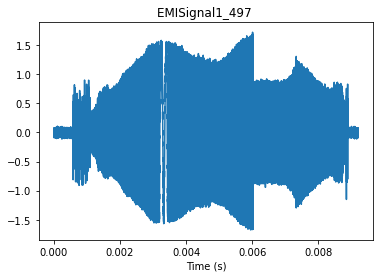

In [5]:
from sigmf import SigMFFile
fs = meta.get_global_field(SigMFFile.SAMPLE_RATE_KEY) # sampling rate from the meta data file
desc = meta.get_global_field(SigMFFile.DESCRIPTION_KEY).split('--') # description from meta data

t_ax = np.arange(len(data))/fs
plt.plot(t_ax, data.real)
plt.xlabel('Time (s)')
plt.title(desc[0])
plt.show()

### Loading a validation example

In [6]:
idx = 500
data,meta = rfcutils.load_dataset_sample(idx, 'sep_val', 'CommSignal3')
sig1,meta1,sig2,meta2 = rfcutils.load_dataset_sample_components(idx, 'sep_val', 'CommSignal3')

print(f"data = sig1 + sig2?: {np.allclose(data, sig1+sig2)}")
print(f"SINR (from components ground truth): {get_sinr(sig1, sig2)} dB")

data = sig1 + sig2?: True
SINR (from components ground truth): -4.4999998807907104 dB


In [7]:
meta

SigMFFile({
    "global": {
        "core:author": "aia-rf@mit.edu",
        "core:datatype": "cf32_le",
        "core:description": "CommSignal2 + CommSignal3",
        "core:sample_rate": 25000000.0,
        "core:sha512": "f57163ca4e269515eb5c1fd5e2ee1bc56846c05c04c20e8dec1cffce132b466733f08b9d88343176a2fd59887da503e0199e77b0dfcf9800dd354644f3425746",
        "core:version": "0.0.2"
    },
    "captures": [
        {
            "core:datetime": "2021-03-25T01:53:03.004812Z",
            "core:frequency": 2400000000.0,
            "core:sample_start": 0
        }
    ],
    "annotations": []
})

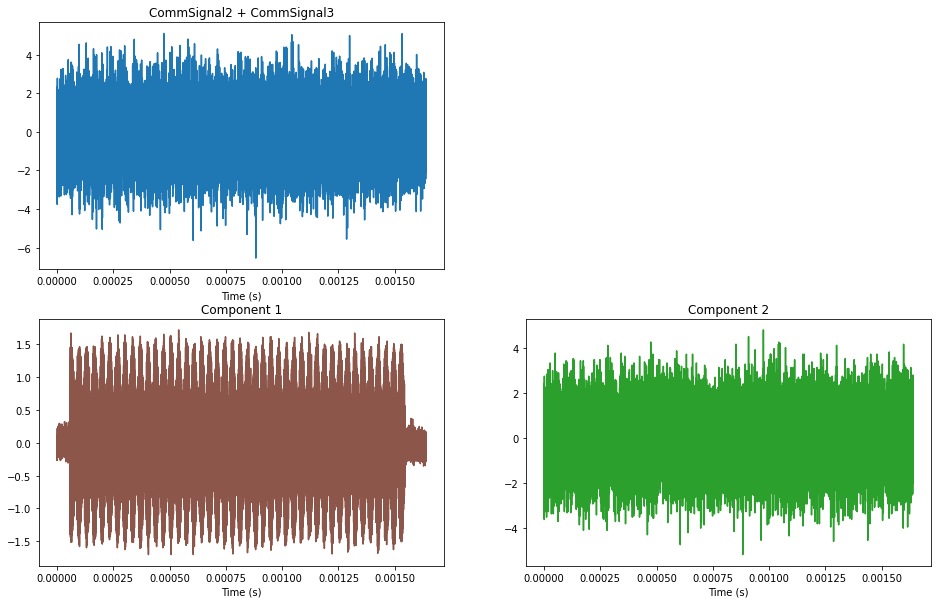

In [8]:
from sigmf import SigMFFile
fs = meta.get_global_field(SigMFFile.SAMPLE_RATE_KEY) # sampling rate from the meta data file
desc = meta.get_global_field(SigMFFile.DESCRIPTION_KEY).split('--') # description from meta data

t_ax = np.arange(len(data))/fs

plt.figure(figsize=(16,10))

plt.subplot(221)
plt.plot(t_ax, data.real)
plt.xlabel('Time (s)')
plt.title(desc[0])

plt.subplot(223)
plt.plot(t_ax, sig1.real, color='tab:brown')
plt.xlabel('Time (s)')
plt.title('Component 1')
plt.subplot(224)
plt.plot(t_ax, sig2.real, color='tab:green')
plt.xlabel('Time (s)')
plt.title('Component 2')
plt.show()

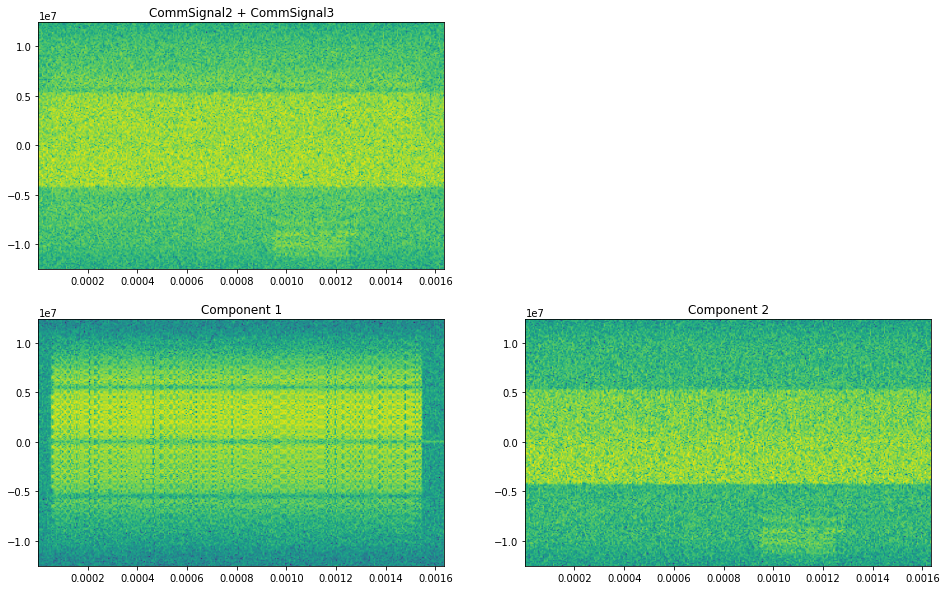

In [9]:
plt.figure(figsize=(16,10))

plt.subplot(221)
plt.specgram(data, Fs=fs, NFFT=256, scale='dB')
plt.title(desc[0])

plt.subplot(223)
plt.specgram(sig1, Fs=fs, NFFT=256, scale='dB')
plt.title('Component 1')
plt.subplot(224)
plt.specgram(sig2, Fs=fs, NFFT=256, scale='dB')
plt.title('Component 2')
plt.show()

### Loading a validation example + Verifying Demodulation

In [10]:
idx = 500
data,meta = rfcutils.load_dataset_sample(idx, 'demod_val', 'EMISignal1')
sig1,meta1,sig2,meta2 = rfcutils.load_dataset_sample_components(idx, 'demod_val', 'EMISignal1')

print(f"data = sig1 + sig2?: {np.allclose(data, sig1+sig2)}")
print(f"Unmitigated BER: {rfcutils.demod_check_ber(rfcutils.matched_filter_demod(data), idx, 'demod_val', 'EMISignal1')}")
print(f"SINR (from components ground truth): {get_sinr(sig1, sig2)} dB")

data = sig1 + sig2?: True
Unmitigated BER: 0.301953125
SINR (from components ground truth): -4.500000476837158 dB


In [11]:
meta

SigMFFile({
    "global": {
        "core:author": "aia-rf@mit.edu",
        "core:datatype": "cf32_le",
        "core:description": "QPSK + EMISignal1",
        "core:sample_rate": 25000000.0,
        "core:sha512": "52a2f1444411c568e450ac096a0c6b4cd14d15ced5b341889acb0758a157eb8f4963de28c04178ec2babc8bd01bb0a7b06fb72976b1d154ba377c92d3c541b98",
        "core:version": "0.0.2"
    },
    "captures": [
        {
            "core:datetime": "2021-03-25T01:31:58.336741Z",
            "core:frequency": 2459960937.5,
            "core:sample_start": 0
        }
    ],
    "annotations": []
})

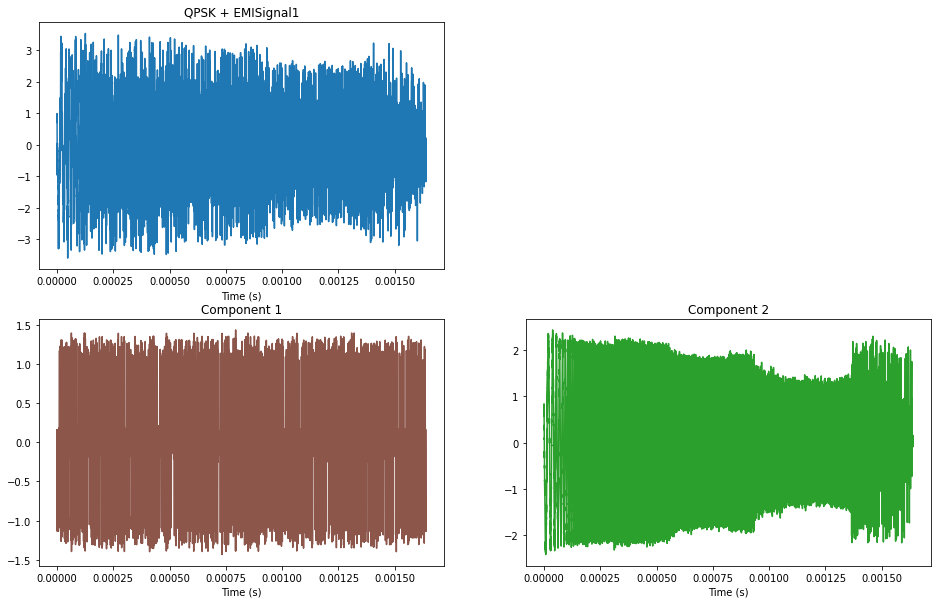

In [12]:
from sigmf import SigMFFile
fs = meta.get_global_field(SigMFFile.SAMPLE_RATE_KEY) # sampling rate from the meta data file
desc = meta.get_global_field(SigMFFile.DESCRIPTION_KEY).split('--') # description from meta data

t_ax = np.arange(len(data))/fs

plt.figure(figsize=(16,10))

plt.subplot(221)
plt.plot(t_ax, data.real)
plt.xlabel('Time (s)')
plt.title(desc[0])

plt.subplot(223)
plt.plot(t_ax, sig1.real, color='tab:brown')
plt.xlabel('Time (s)')
plt.title('Component 1')
plt.subplot(224)
plt.plot(t_ax, sig2.real, color='tab:green')
plt.xlabel('Time (s)')
plt.title('Component 2')
plt.show()

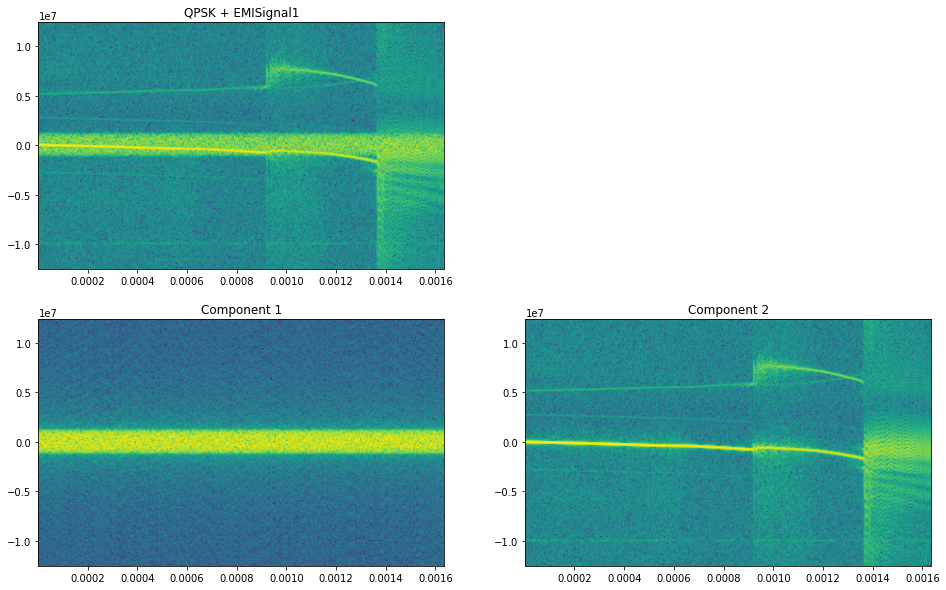

In [13]:
plt.figure(figsize=(16,10))

plt.subplot(221)
plt.specgram(data, Fs=fs, NFFT=256, scale='dB')
plt.title(desc[0])

plt.subplot(223)
plt.specgram(sig1, Fs=fs, NFFT=256, scale='dB')
plt.title('Component 1')
plt.subplot(224)
plt.specgram(sig2, Fs=fs, NFFT=256, scale='dB')
plt.title('Component 2')
plt.show()

In [14]:
# get bit estimate in the form of a numpy array
bit_est = rfcutils.matched_filter_demod(data)

# pass through 
ber = rfcutils.demod_check_ber(bit_est, idx, 'demod_val', 'EMISignal1')
print(ber)

0.301953125


---

## Types of Data

### Training Set

In [15]:
t_axis = np.arange(5e5)/25e6*1e3

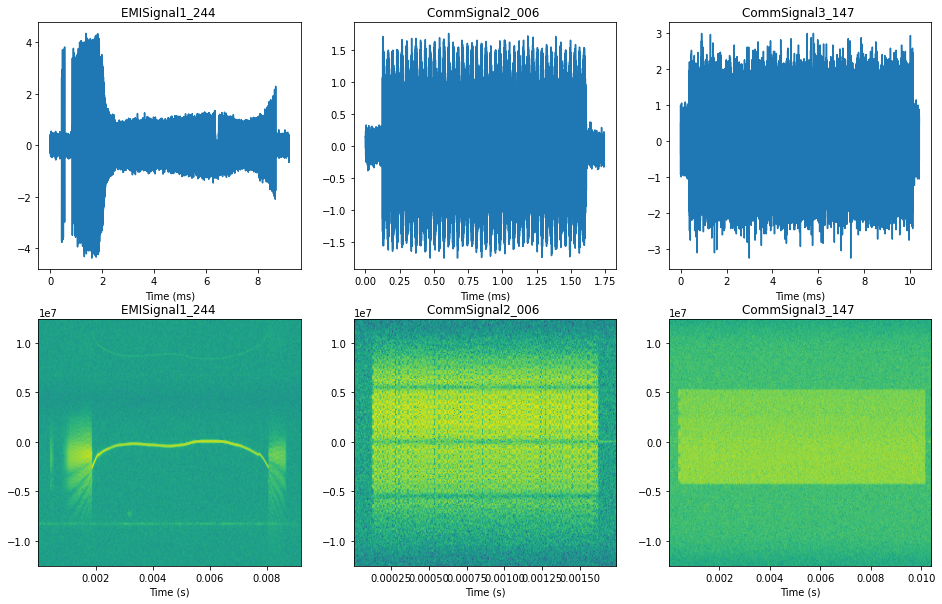

In [16]:
fs = 25e6
plt.figure(figsize=(16,10))

data1,meta1 = rfcutils.load_dataset_sample(1, 'train_frame', 'EMISignal1')
desc1 = meta1.get_global_field(SigMFFile.DESCRIPTION_KEY).split('--') # description from meta data
plt.subplot(231)
plt.plot(t_axis[:len(data1)],data1.real)
plt.xlabel('Time (ms)')
plt.title(desc1[0])
plt.subplot(234)
plt.specgram(data1, Fs=fs, NFFT=256, scale='dB')
plt.xlabel('Time (s)')
plt.title(desc1[0])


data2,meta2 = rfcutils.load_dataset_sample(1, 'train_frame', 'CommSignal2')
desc2 = meta2.get_global_field(SigMFFile.DESCRIPTION_KEY).split('--') # description from meta data
plt.subplot(232)
plt.plot(t_axis[:len(data2)],data2.real)
plt.xlabel('Time (ms)')
plt.title(desc2[0])
plt.subplot(235)
plt.specgram(data2, Fs=fs, NFFT=256, scale='dB')
plt.xlabel('Time (s)')
plt.title(desc2[0])


data3,meta3 = rfcutils.load_dataset_sample(1, 'train_frame', 'CommSignal3')
desc3 = meta3.get_global_field(SigMFFile.DESCRIPTION_KEY).split('--') # description from meta data
plt.subplot(233)
plt.plot(t_axis[:len(data3)],data3.real)
plt.xlabel('Time (ms)')
plt.title(desc3[0])
plt.subplot(236)
plt.specgram(data3, Fs=fs, NFFT=256, scale='dB')
plt.xlabel('Time (s)')
plt.title(desc3[0])

plt.show()

### Validation Set -- Demod Challenge

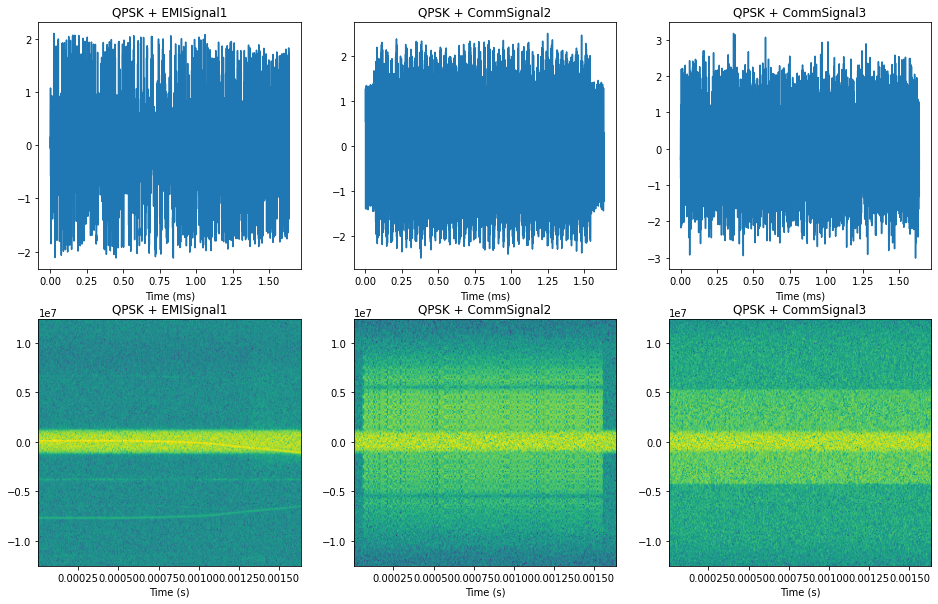

In [17]:
fs = 25e6
plt.figure(figsize=(16,10))

data1,meta1 = rfcutils.load_dataset_sample(0, 'demod_val', 'EMISignal1')
desc1 = meta1.get_global_field(SigMFFile.DESCRIPTION_KEY).split('--') # description from meta data
plt.subplot(231)
plt.plot(t_axis[:len(data1)],data1.real)
plt.xlabel('Time (ms)')
plt.title(f"{desc1[0]}")
plt.subplot(234)
plt.specgram(data1, Fs=fs, NFFT=256, scale='dB')
plt.xlabel('Time (s)')
plt.title(f"{desc1[0]}")


data2,meta2 = rfcutils.load_dataset_sample(0, 'demod_val', 'CommSignal2')
desc2 = meta2.get_global_field(SigMFFile.DESCRIPTION_KEY).split('--') # description from meta data
plt.subplot(232)
plt.plot(t_axis[:len(data2)],data2.real)
plt.xlabel('Time (ms)')
plt.title(f"{desc2[0]}")
plt.subplot(235)
plt.specgram(data2, Fs=fs, NFFT=256, scale='dB')
plt.xlabel('Time (s)')
plt.title(f"{desc2[0]}")


data3,meta3 = rfcutils.load_dataset_sample(0, 'demod_val', 'CommSignal3')
desc3 = meta3.get_global_field(SigMFFile.DESCRIPTION_KEY).split('--') # description from meta data
plt.subplot(233)
plt.plot(t_axis[:len(data3)],data3.real)
plt.xlabel('Time (ms)')
plt.title(f"{desc3[0]}")
plt.subplot(236)
plt.specgram(data3, Fs=fs, NFFT=256, scale='dB')
plt.xlabel('Time (s)')
plt.title(f"{desc3[0]}")

plt.show()

### Validation Set -- Sep Challenge

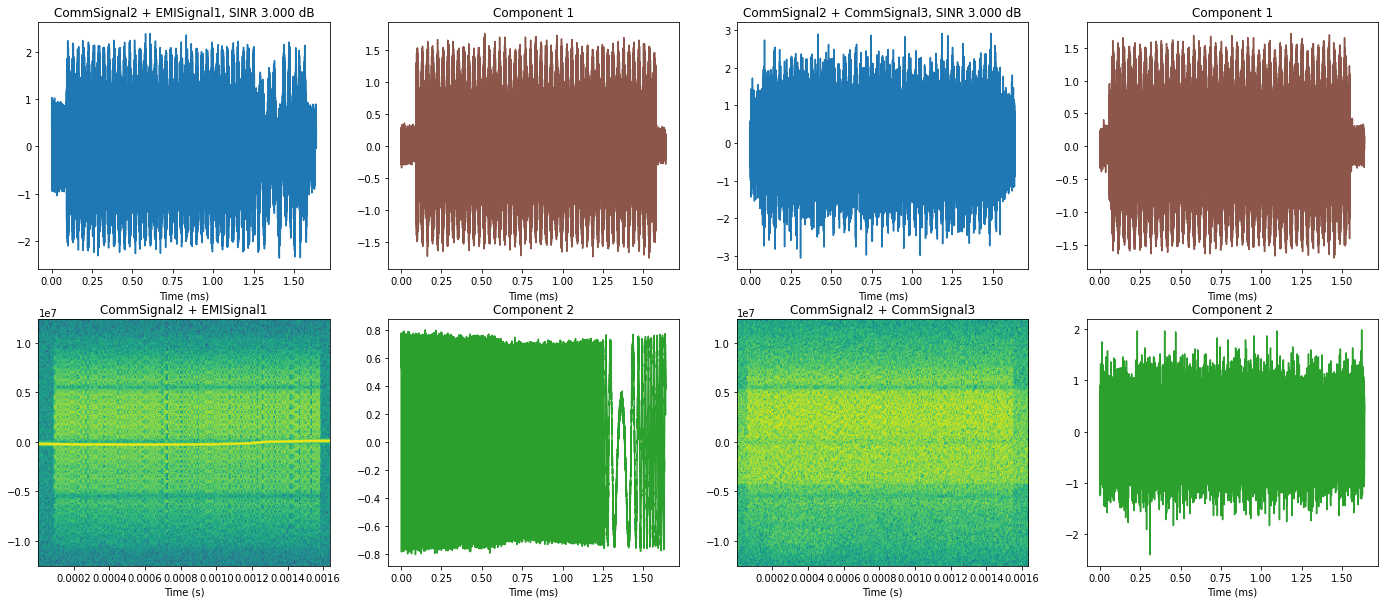

In [18]:
fs = 25e6
plt.figure(figsize=(24,10))

data1,meta1 = rfcutils.load_dataset_sample(0, 'sep_val', 'EMISignal1')
sig11,meta11,sig12,meta12 = rfcutils.load_dataset_sample_components(0, 'sep_val', 'EMISignal1')
desc1 = meta1.get_global_field(SigMFFile.DESCRIPTION_KEY).split('--') # description from meta data
plt.subplot(241)
plt.plot(t_axis[:len(data1)],data1.real)
plt.xlabel('Time (ms)')
plt.title(f"{desc1[0]}, SINR {get_sinr(sig11, sig12):.03f} dB")
plt.subplot(245)
plt.specgram(data1, Fs=fs, NFFT=256, scale='dB')
plt.xlabel('Time (s)')
plt.title(f"{desc1[0]}")

plt.subplot(242)
plt.plot(t_axis[:len(sig11)],sig11.real, color='tab:brown')
plt.xlabel('Time (ms)')
plt.title('Component 1')
plt.subplot(246)
plt.plot(t_axis[:len(sig12)],sig12.real, color='tab:green')
plt.xlabel('Time (ms)')
plt.title('Component 2')

assert np.allclose(data1, sig11 + sig12)


data3,meta3 = rfcutils.load_dataset_sample(0, 'sep_val', 'CommSignal3')
sig31,meta31,sig32,meta32 = rfcutils.load_dataset_sample_components(0, 'sep_val', 'CommSignal3')
desc3 = meta3.get_global_field(SigMFFile.DESCRIPTION_KEY).split('--') # description from meta data
plt.subplot(243)
plt.plot(t_axis[:len(data3)],data3.real)
plt.xlabel('Time (ms)')
plt.title(f"{desc3[0]}, SINR {get_sinr(sig31, sig32):.03f} dB")
plt.subplot(247)
plt.specgram(data3, Fs=fs, NFFT=256, scale='dB')
plt.xlabel('Time (s)')
plt.title(f"{desc3[0]}")

plt.subplot(244)
plt.plot(t_axis[:len(sig31)],sig31.real, color='tab:brown')
plt.xlabel('Time (ms)')
plt.title('Component 1')
plt.subplot(248)
plt.plot(t_axis[:len(sig32)],sig32.real, color='tab:green')
plt.xlabel('Time (ms)')
plt.title('Component 2')

assert np.allclose(data3, sig31 + sig32)

plt.show()

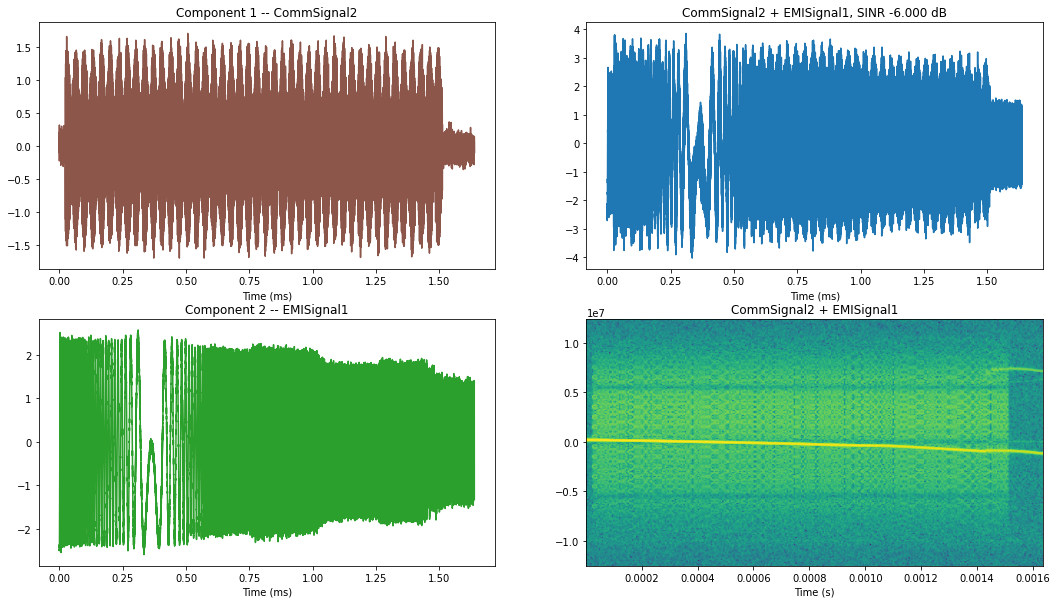

In [19]:
fs = 25e6
plt.figure(figsize=(18,10))

data1,meta1 = rfcutils.load_dataset_sample(642, 'sep_val', 'EMISignal1')
sig11,meta11,sig12,meta12 = rfcutils.load_dataset_sample_components(642, 'sep_val', 'EMISignal1')
desc1 = meta1.get_global_field(SigMFFile.DESCRIPTION_KEY).split('--') # description from meta data
plt.subplot(222)
plt.plot(t_axis[:len(data1)],data1.real)
plt.xlabel('Time (ms)')
plt.title(f"{desc1[0]}, SINR {get_sinr(sig11, sig12):.03f} dB")
plt.subplot(224)
plt.specgram(data1, Fs=fs, NFFT=256, scale='dB')
plt.xlabel('Time (s)')
plt.title(f"{desc1[0]}")

plt.subplot(221)
plt.plot(t_axis[:len(sig11)],sig11.real, color='tab:brown')
plt.xlabel('Time (ms)')
plt.title('Component 1 -- CommSignal2')
plt.subplot(223)
plt.plot(t_axis[:len(sig12)],sig12.real, color='tab:green')
plt.xlabel('Time (ms)')
plt.title('Component 2 -- EMISignal1')

assert np.allclose(data1, sig11 + sig12)

---

## Generating new mixtures

You can create new mixture examples using the `rfcutils.create_sep_mixture` and `rfcutils.create_demod_mixture` function. These functions replicate how the mixture examples in the dataset were generated.

Syntax: rfcutils.create_sep_mixture(signal type, target_sinr_db=target sinr, dataset_type=dataset type, seed=seed)<br>
or rfcutils.create_demod_mixture(signal type, target_sinr_db=target sinr, dataset_type=dataset type, seed=seed)
* signal type: 'EMISignal1', 'CommSignal2', 'CommSignal3'
* dataset type: 'train' (draws from all but the last 50 examples from train_frame), 'val' (creates "unseen" examples by using last 50 examples from train_frame), 'all' (draws from all examples from train_frame)
* target SINR (in dB): our challenge will use SINR between -12 to 3 dB; the function accepts any numerical value.
* seed: provide a seed if you want replicability in generating the mixture (defaults to None)

In [20]:
sig_mixture, sig1, sig2 = rfcutils.create_sep_mixture('EMISignal1', target_sinr_db=-3, seed=None, dataset_type="all")

In [21]:
sig_mixture, sig1, sig2, msg_bits = rfcutils.create_demod_mixture('CommSignal2', target_sinr_db=-3, seed=None, dataset_type="train")